<a href="https://colab.research.google.com/github/Fatikah002/PCVK_Fatikah/blob/main/Week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from google.colab.patches import cv2_imshow
from PIL import Image
import os

## Konvlusi tanpa Library
**Membuat fungsi konvolusi**
Fungsi konsivolusi yang dibuat memiliki parameter berupa :
1. citra masukan
2. kernel berupa matriks untuk memfilter citra,
3. nilai stride / besarnya pergeseran untuk setiap konvolusi,
4. nilai pad yang akan ditambahkan pada citra


In [31]:
# Buat fungsi konvolusi (Tanpa OpenCV filter2d)
def convolution2d(image, kernel,stride, padding):
    # ubah ke float untuk perhitungan
    image = image.astype(float)
    k_height, k_width = kernel.shape
    i_height, i_width = image.shape

    # padding opsional
    if padding:
        pad_h = k_height // 2
        pad_w = k_width // 2
        image_padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    else:
        image_padded = image

    output = np.zeros_like(image)

    for i in range(i_height):
        for j in range(i_width):
            region = image_padded[i:i+k_height, j:j+k_width]
            output[i, j] = np.sum(region * kernel)

    return output

In [32]:
img = cv.imread('/content/drive/MyDrive/PCVK/Images/mandrill.tiff')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


In [33]:
# image sharpen
kernel_sharpen = np.array([[0, -1, 0],
                           [-1,5,-1],
                           [0,-1,0]])
# Emboss Filter
emboss_kernel = np.array([
    [-2,-1,0],
    [-1,1,1],
    [0,1,2]
])

# Sobel (Edge Detection)
sobel_kernel = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

#Canny-like Edge Detection
canny_kernel = np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
])

#Gaussian Blur (Approximation)
gaussian_kernel = (1/16) * np.array([
    [1,2,1],
    [2,4,2],
    [1,2,1]
])

In [34]:
convolution2d(img_gray, kernel_sharpen,1,2)


array([[ 553.,  -15.,   60., ...,  150.,  326.,  607.],
       [ 257.,  179.,  -63., ...,  167.,  249.,  218.],
       [  84.,  210.,  -65., ...,  111.,   35.,  122.],
       ...,
       [ 293.,  168.,  131., ...,   56.,  114.,  143.],
       [ 487.,  262.,  241., ...,  143.,  159.,  183.],
       [-112., -110.,  -91., ...,  -52.,  -71.,  -53.]])

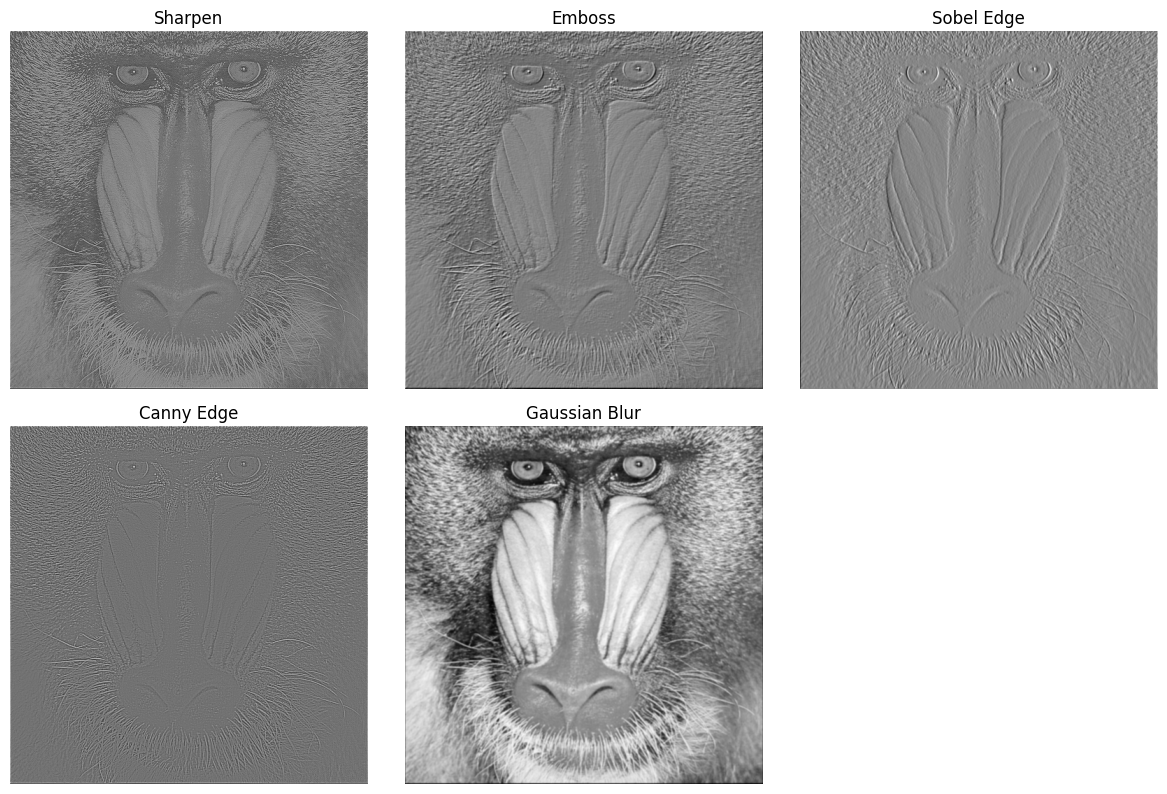

In [35]:
filters = {
    "Sharpen": kernel_sharpen,
    "Emboss": emboss_kernel,
    "Sobel Edge": sobel_kernel,
    "Canny Edge": canny_kernel,
    "Gaussian Blur": gaussian_kernel
}

plt.figure(figsize=(12, 12))

for i, (name, kernel) in enumerate(filters.items(), 1):
    result = convolution2d(img_gray, kernel, stride=1, padding=1)
    plt.subplot(3, 3, i)
    plt.imshow(result, cmap='gray')
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()


#### FILTER LIBRARY DAN FILTER MODERN


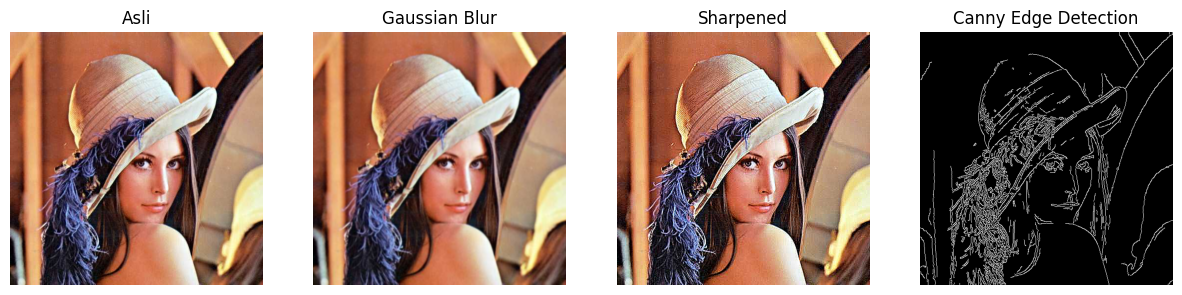

In [37]:
# Percobaan 1
# Fungsi tampil berdampingan
def show_side_by_side(images, titles, figsize=(15,5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 2:  # grayscale
            plt.subplot(1, len(images), i+1)
            plt.imshow(img, cmap="gray")
        else:  # color
            plt.subplot(1, len(images), i+1)
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
    plt.show()

img = cv.imread("/content/drive/MyDrive/PCVK/Images/lena.jpg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

blur = cv.GaussianBlur(img, (7,7), 1)
edges = cv.Canny(cv.cvtColor(img, cv.COLOR_BGR2GRAY), 100, 200)
sharpen_kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
sharpened = cv.filter2D(img, -1, sharpen_kernel)
show_side_by_side([img, blur, sharpened, edges],
                  ["Asli", "Gaussian Blur", "Sharpened", "Canny Edge Detection"])


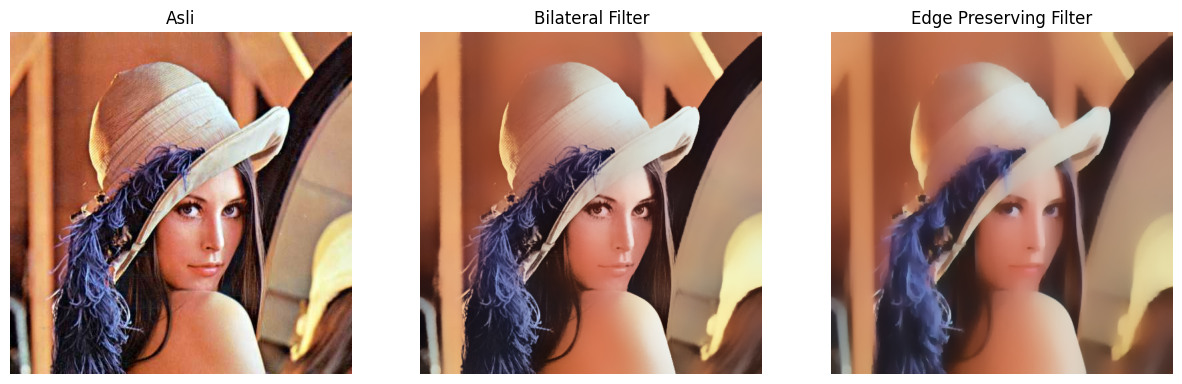

In [38]:
# Percobaan 2
#Filter Modern dari OpenCV
# Bilateral Filter (edge-preserving)
bilateral = cv.bilateralFilter(img, 50, 100, 100)

# Edge Preserving Filter (alternatif Guided Filter)
edge_preserve = cv.edgePreservingFilter(img, flags=1, sigma_s=100, sigma_r=0.9)

show_side_by_side([img, bilateral, edge_preserve],
                  ["Asli", "Bilateral Filter", "Edge Preserving Filter"])

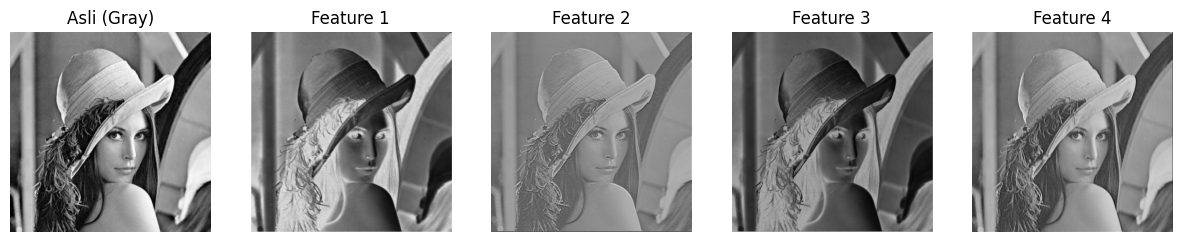

In [102]:
# Percobaan 3
#Filter Feature Map yang digunakan pada CNN, lakukan running code bagian ini beberapa kali dan perhatikan hasilnya
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv1(x)

model = SimpleCNN()

# Ubah gambar ke tensor
img_tensor = torch.tensor(img_gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0

# Hasil CNN
with torch.no_grad():
    features = model(img_tensor)

# Visualisasi feature maps
feature_maps = [features[0,i].numpy() for i in range(features.shape[1])]
show_side_by_side([img_gray] + feature_maps, ['Asli (Gray)'] + [f'Feature {i+1}' for i in range(len(feature_maps))])


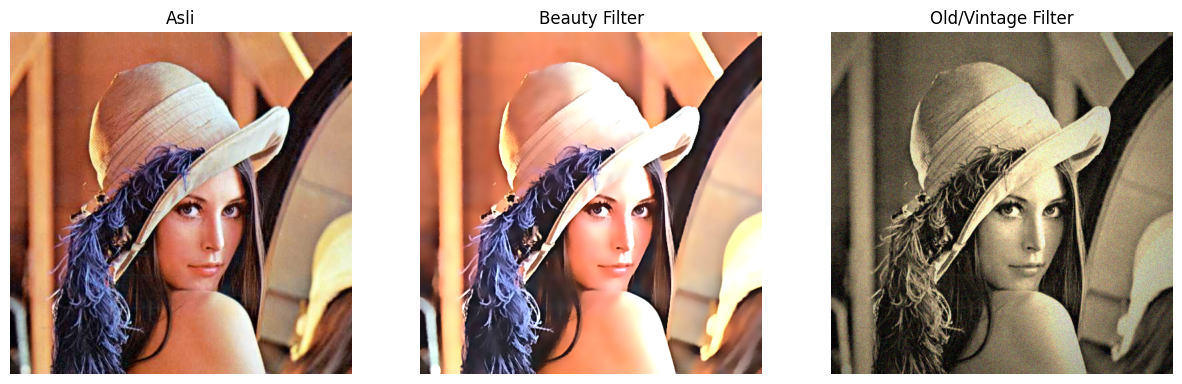

In [104]:
# Percobaan 4
# ===================
# 1. Beauty Filter
# ===================
# Step 1: Smoothing kulit dengan bilateral filter
smooth = cv.bilateralFilter(img, d=15, sigmaColor=75, sigmaSpace=75)

# Step 2: Unsharp masking (pertajam mata/bibir)
gaussian = cv.GaussianBlur(smooth, (0,0), 3)
sharpened = cv.addWeighted(smooth, 1.5, gaussian, -0.5, 0)

# Step 3: Brightness & contrast
alpha = 1.2   # contrast
beta = 15     # brightness
beauty = cv.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

# ===================
# 2. Old/Vintage Filter
# ===================
# Step 1: Sepia tone
sepia_kernel = np.array([[0.272, 0.534, 0.131],
                         [0.349, 0.686, 0.168],
                         [0.393, 0.769, 0.189]])
sepia = cv.transform(img, sepia_kernel)
sepia = np.clip(sepia, 0, 255).astype(np.uint8)

# Step 2: Vignette
rows, cols = img.shape[:2]
kernel_x = cv.getGaussianKernel(cols, cols*0.6)
kernel_y = cv.getGaussianKernel(rows, rows*0.6)
kernel = kernel_y * kernel_x.T
mask = kernel / kernel.max()
vignette = np.copy(sepia)
for i in range(3):
    vignette[:,:,i] = vignette[:,:,i] * mask

# Step 3: Noise/Grain
noise = np.random.normal(0, 15, vignette.shape).astype(np.int16)
old_img = np.clip(vignette.astype(np.int16) + noise, 0, 255).astype(np.uint8)
show_side_by_side([img, beauty, old_img],
                  ["Asli", "Beauty Filter", "Old/Vintage Filter"])



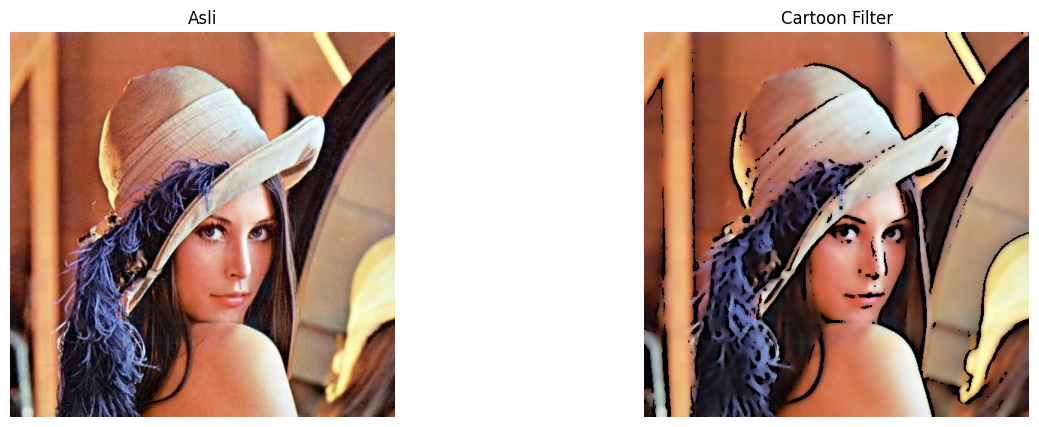

In [105]:
# Percobaan 5
#Filter Anime / Cartoon
# Step 1: Edge detection (pakai median blur dulu agar gambar menjadi lebih halus)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_blur = cv.medianBlur(gray, 7)
edges = cv.adaptiveThreshold(gray_blur, 255,
                             cv.ADAPTIVE_THRESH_MEAN_C,
                             cv.THRESH_BINARY, 9, 9)

# Step 2: Bilateral filter untuk smoothing warna
color = cv.bilateralFilter(img, d=9, sigmaColor=200, sigmaSpace=200)

# Step 3: Gabungkan (cartoonize)
cartoon = cv.bitwise_and(color, color, mask=edges)

# Tampilkan
show_side_by_side([img, cartoon], ["Asli", "Cartoon Filter"])


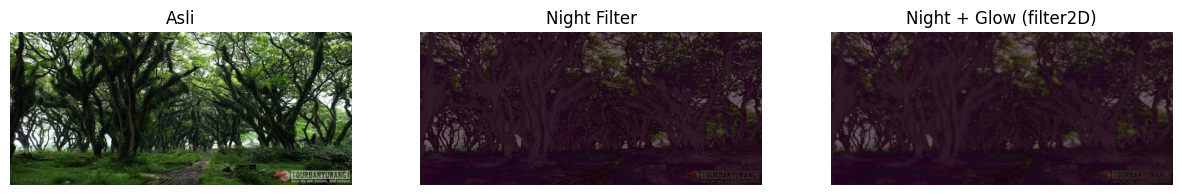

In [107]:
# Percobaan 6
#Night Filter
img = cv.imread("/content/drive/MyDrive/PCVK/Images/djawatan.jpg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Step 1: Gelapkan (contrast turun, brightness negatif)
night = cv.convertScaleAbs(img, alpha=0.6, beta=-40)

# Step 2: Tambah bias biru
blue_tint = np.full_like(night, (50, 0, 100))  # BGR
night = cv.addWeighted(night, 0.8, blue_tint, 0.2, 0)

# Step 3: Efek glow di area terang dengan filter2D (blur kernel)
kernel = np.ones((15,15), np.float32) / 225
glow = cv.filter2D(night, -1, kernel)

# Kombinasikan asli + glow
night_glow = cv.addWeighted(night, 0.7, glow, 0.3, 0)

show_side_by_side([img, night, night_glow],
                  ["Asli", "Night Filter", "Night + Glow (filter2D)"])


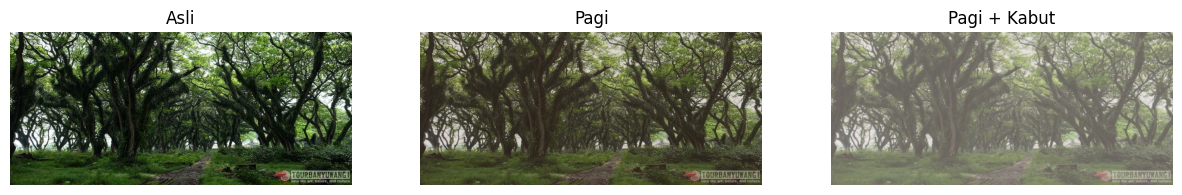

In [108]:
# Percobaan 7
#Filter Suasana pagi dan Kabut
# ===========================
# Step 1: Kurangi kontras & cerahkan
alpha = 0.9   # contrast
beta = 20     # brightness
soft = cv.convertScaleAbs(img, alpha=alpha, beta=beta)

# Step 2: Tambahkan warm tone (kemerahan / oranye)
warm_tint = np.full_like(soft, (40, 70, 120))  # BGR
pagi = cv.addWeighted(soft, 0.8, warm_tint, 0.2, 0)

# Step 3: Tambahkan haze (kabut tipis) dengan filter2D
kernel = cv.getGaussianKernel(3, 3)
kernel = kernel @ kernel.T  # jadikan 2D kernel
kabut = cv.filter2D(pagi, -1, kernel)

# tambahkan layer putih untuk kabut lebih nyata
white_layer = np.full_like(pagi, 255)
kabut = cv.addWeighted(kabut, 0.7, white_layer, 0.3, 0)

show_side_by_side([img, pagi, kabut],
                  ["Asli", "Pagi", "Pagi + Kabut"])
